In [1]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from pathlib import Path

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer, 
                          get_scheduler)
import torch
import bitsandbytes as bnb

/Users/Cecilia/text-project/text-proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/Cecilia/text-project/text-proj/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [2]:
# https://www.kaggle.com/datasets/asaniczka/data-scientist-linkedin-job-postings
import kagglehub
# Download latest version
path = kagglehub.dataset_download("asaniczka/data-scientist-linkedin-job-postings")

print("Path to dataset files:", path)
files = os.listdir(path)
# Print the names of the files
for file in files:
    print(file)

Path to dataset files: /Users/Cecilia/.cache/kagglehub/datasets/asaniczka/data-scientist-linkedin-job-postings/versions/103
postings.csv


In [3]:
postings = pd.read_csv(path+'/postings.csv')
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Remote,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Onsite,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Onsite,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Remote,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Hybrid,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [ ]:
postings.columns
# may just need 'title', 'job_summary', 'job_skills'

Index(['job_title', 'company', 'job_location', 'job_link', 'first_seen',
       'search_city', 'search_country', 'job level', 'job_type', 'job_summary',
       'job_skills'],
      dtype='object')

### Processing

In [68]:
postings.drop_duplicates(inplace=True)

In [69]:
# Apply conditions to create 'job_type'
patterns = {
    'Data Scientist': r'Data\s*Scientist|Data\s*Science|Scientist',  # Match both "Data Scientist" and "Data Science"
    'Data Analyst (BI)': r'Data\s*Analyst|Data\s*Research\s*Analyst|Analyst|Data\s*Analytics|BI|Business\s*Intelligence|Analytics|Visualization|Data\s*Analysis',  # Add "Data Research Analyst"
    'Data Engineer': r'Data\s*Engineer|Database\s*Engineer|Engineer',  # Consider "Database Engineer" as well
    'Software Engineer': r'Software\s*Engineer|Developer|Programmer|Software',
    'Statistician': r'\s*Statistician',
    'Modeler': r'\s*Modeler',
    'Consultant': r'\s*Consultant',
    'Specialist': r'\s*Specialist'
}

# Initialize 'job_type' column with 'Unknown'
postings['job_type'] = 'Unknown'

# Apply patterns to classify job titles
for job_type, pattern in patterns.items():
    postings.loc[postings['job_title'].str.contains(pattern, case=False, na=False, regex=True), 'job_type'] = job_type

# Show the first few rows
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [76]:
postings[postings['job_type']=='Unknown']['job_title'].value_counts()
data = postings[postings['job_type']!='Unknown']
data.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


# Text Processing

Cleaning Text: Remove unwanted characters, URLs, and unnecessary whitespace.
Lowercasing: Convert all text to lowercase to maintain consistency.
Tokenization: Split the text into words or tokens.
Stop Words Removal: Remove common words that may not add value to your analysis (e.g., "and", "the").
Stemming/Lemmatization: Reduce words to their base or root form.

In [77]:
cols = ['job_title', 'job_summary', 'job_skills', 'job_type']
data = data[cols]
data.head()

,job_title,job_summary,job_skills,job_type
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI)
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI)
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI)


In [78]:
data['job_type'].value_counts()

job_type
Data Scientist       1691
Data Engineer        1335
Data Analyst (BI)     895
Software Engineer     282
Specialist             49
Consultant             44
Statistician           11
Modeler                 8
Name: count, dtype: int64

In [79]:
data.dropna(subset=['job_title', 'job_summary', 'job_skills'], inplace=True)
data.isna().sum()

job_title      0
job_summary    0
job_skills     0
job_type       0
dtype: int64

In [17]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import json

# Load JSON file
with open("skills.json", "r") as file:
    skills_data = json.load(file)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Cecilia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Cecilia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Cecilia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning for job_summary
def clean_text_summary(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Retain keywords (skills) and remove stop words
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word in skills_data or word not in stop_words
    ]
    return ' '.join(cleaned_tokens)

# Text cleaning for job_skills (only remove special characters and notations)
def clean_text_skills(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    return text

# Assuming your DataFrame is named 'data'
# Apply cleaning to job_summary and job_skills
data['cleaned_job_summary'] = data['job_summary'].apply(clean_text_summary)
data['cleaned_job_skills'] = data['job_skills'].apply(clean_text_skills)

# Save the cleaned data
data.to_csv('cleaned_data.csv', index=False)

# Preview the cleaned data
data.head()

,job_title,job_summary,job_skills,job_type,cleaned_job_summary,cleaned_job_skills
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI),choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer,job responsibility deployment inscope configur...,server storage backup networking virtualizatio...
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI),success factor knowledge schedule monday frida...,data management hr data retention controls cal...
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer,company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI),national grid renewables leading north america...,data analyst operational assessment wind energ...


### NER


In [85]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.2 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [86]:
import spacy

# Load a pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")  # Replace with your fine-tuned model if available

# Define a function to extract skills from job summary
def extract_skills_from_summary(job_summary):
    """
    Extracts key job skills from the given job summary using spaCy NER.
    """
    doc = nlp(job_summary)
    skills = []

    # Loop through the named entities and extract potential skills
    for ent in doc.ents:
        # You can filter by entity type or customize this further
        if ent.label_ in ["SKILL", "TECH", "TOOL", "LANGUAGE"]:  # Customize labels as needed
            skills.append(ent.text)
    
    # Add a fallback for phrases that might not be tagged as entities
    # Example: Checking dependency parsing for noun phrases
    for chunk in doc.noun_chunks:
        if "knowledge" in chunk.text.lower() or "experience" in chunk.text.lower():
            skills.append(chunk.root.text)

    return list(set(skills))  # Remove duplicates

In [90]:
extract_skills_from_summary(data['cleaned_job_summary'][0])

['experience', 'hyperion', 'associate', 'process']

NER didn't work well in our case.

### Baseline Summarization

cite: https://towardsdatascience.com/setting-up-a-text-summarisation-project-daae41a1aaa3

In [96]:
from transformers import pipeline
#summarizer = pipeline("summarization")
summarizer = pipeline("summarization", model='facebook/bart-large-cnn')
summarizer.model.config.__getattribute__('_name_or_path')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


'facebook/bart-large-cnn'

In [97]:
import numpy as np
# split the dataset into train, val, and test
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=44), [int(0.8*len(data)), int((0.9)*len(data))])
df_train.to_csv('train.csv', index=False)
df_val.to_csv('val.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [103]:
df_test = pd.read_csv('test.csv')
ref_summaries = list(df_test['job_type'])
texts = list(df_test['cleaned_job_summary'])
summarizer(texts[0], max_length=30)

Your min_length=56 must be inferior than your max_length=30.
/Users/Cecilia/text-project/text-proj/lib/python3.10/site-packages/transformers/generation/utils.py:1244: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (30). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


[{'summary_text': ' data analyst location hartford ct raleigh nc duration fulltime job description least year experience working healthcare business data analyst health plan'}]

In [106]:
candidate_summaries = []

for i, text in enumerate(texts):
    if i % 100 == 0:
        print(i)
    try:
        # Generate summary using the summarizer
        candidate = summarizer(text, min_length=5, max_length=30)
        
        # Ensure the summarizer returned a valid result
        if candidate:
            candidate_summaries.append(candidate[0].get('summary_text', 'No summary text found'))
        else:
            candidate_summaries.append('No summary generated')
    
    except Exception as e:
        # Catch any exceptions during the summarization process
        print(f"Error summarizing text at index {i}: {e}")
        candidate_summaries.append('Error during summarization')

file = open("zero-shot-summaries.txt", "w")
for s in candidate_summaries:
    file.write(s + "\n")
file.close()
candidate_summaries[:5]

0
Error summarizing text at index 76: index out of range in self
100
Error summarizing text at index 137: index out of range in self
Error summarizing text at index 164: index out of range in self
Error summarizing text at index 189: index out of range in self
200
Error summarizing text at index 276: index out of range in self
Error summarizing text at index 292: index out of range in self
300
Error summarizing text at index 346: index out of range in self
Error summarizing text at index 388: index out of range in self
400
Error summarizing text at index 416: index out of range in self
Error summarizing text at index 422: index out of range in self


[' data analyst location hartford ct raleigh nc duration fulltime job description least year experience working healthcare business data analyst health plan',
 'Hire a data engineer to revolutionize dating industry. Hire a product manager to help build a software hardware talent innovative company team.',
 'Aurora co icr is looking for a data scientist with bayesian statistic background. The data scientist is expected to work independently on',
 'Program designed build fundamental understanding operation power grid realtime system operation perspective thorough knowledge wholesale market operate critical knowledge longterm infrastructure planning process.',
 ' data analyst leatherhead uk salary data analyst want use skill make real impact education world enjoy seeing work bringing people data together best way person']

In [ ]:
from evaluate import load

# Load the ROUGE metric
metric = load("rouge")

def calc_rouge_scores(candidates, references):
    """
    Calculate ROUGE scores for candidate summaries against reference summaries.

    Args:
    - candidates (list of str): List of generated summaries.
    - references (list of str): List of reference summaries.

    Returns:
    - dict: ROUGE scores rounded to 1 decimal place.
    """
    if not candidates or not references:
        raise ValueError("Candidates and references must not be empty.")
    if len(candidates) != len(references):
        raise ValueError("Candidates and references must have the same length.")

    # Compute ROUGE scores
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    
    # Handle the case where the result is a dictionary of scalar values
    if isinstance(result, dict):
        result = {key: round(value * 100, 1) for key, value in result.items()}
    else:
        raise ValueError(f"Unexpected result format: {result}")

    return result

# Ensure candidate_summaries and texts are defined properly
calc_rouge_scores(candidate_summaries, texts)

{'rouge1': np.float64(14.4),
 'rouge2': np.float64(13.3),
 'rougeL': np.float64(14.0),
 'rougeLsum': np.float64(14.1)}

#### Evaluation for baseline: ROUGE Scores Breakdown:
1. rouge1 (14.4%):

What it measures: Unigram (single-word) overlap between the candidate and reference summaries.
Interpretation: 14.4% is relatively low for ROUGE-1, especially in competitive summarization tasks where scores typically range higher (20-40% or more). However, it may still indicate that some key terms and words from the reference are retained.

2. rouge2 (13.3%):

What it measures: Bigram (two-word) overlap.
Interpretation: A score of 13.3% is also on the lower end for bigram overlap. It suggests the candidate summary may not maintain as much of the structure or combinations of words from the reference summary. Higher values (20%+) are typically seen in stronger models.

3. rougeL (14.0%):

What it measures: Longest common subsequence (LCS) overlap, which evaluates the order of words.
Interpretation: A score of 14.0% is relatively low. Stronger models usually produce ROUGE-L scores in the range of 20-30%, indicating that they maintain a better word order and sequence.

4. rougeLsum (14.1%):

What it measures: Similar to ROUGE-L but focused on the overall summary.
Interpretation: This score is slightly higher than ROUGE-L, but still low. A higher ROUGE-Lsum (around 20-30%) indicates the candidate summary closely follows the reference summary's overall structure.

### Conclusion
For baseline models or simple approaches, these scores may be reasonable, as early-stage or simpler models might achieve ROUGE scores in the range of 10-20%.

#### Improvememt:
- achieve higher ROUGE Scores (depends on context and use)
- may use LLM or Prompt Engineering to prettify the summary we extracted (more smooth and human-sound like)

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Read the data
data = pd.read_csv('cleaned_data.csv')

# Read the text summaries
with open('zero-shot-summaries.txt', 'r') as file:
    summaries = file.read().splitlines()  # Assuming each line in the file is a separate summary

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fill NaN values in 'data["cleaned_job_summary"]' and concatenate with summaries from the file
summaries_filled = data["cleaned_job_summary"].fillna("")  # Fill NaN values in the summaries

# Assuming that the number of summaries matches the number of rows in the 'cleaned_job_summary' column
# Concatenate the original job summaries and the external summaries
combined_text = summaries_filled.tolist() + summaries  # Concatenate lists of summaries

# Create the TF-IDF matrix for the combined text
tfidf_matrix = vectorizer.fit_transform(combined_text)

# Calculate cosine similarity between the original job summaries and the external summaries
cosine_scores = cosine_similarity(tfidf_matrix[:len(data)], tfidf_matrix[len(data):])

# The cosine_scores matrix contains the similarity between each original job summary and each external summary
# You might want to choose the highest similarity score for each job summary
relevancy_scores = cosine_scores.max(axis=1)  # Take the maximum similarity score for each job summary

# Add relevancy scores to the dataset
data["relevancy_score"] = relevancy_scores

# Optionally, save the updated data with relevancy scores to a new CSV file
#data.to_csv('updated_data.csv', index=False)
data

,job_title,job_summary,job_skills,job_type,cleaned_job_summary,cleaned_job_skills,relevancy_score
0,Technical Data Analyst,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",Data Analyst (BI),choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...,0.232006
1,Data Center Engineer - Minneapolis,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",Data Engineer,job responsibility deployment inscope configur...,server storage backup networking virtualizatio...,0.375514
2,Data Analyst,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",Data Analyst (BI),success factor knowledge schedule monday frida...,data management hr data retention controls cal...,0.208206
3,Data Engineer II - NBC Sports Next,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",Data Engineer,company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...,0.653797
4,Data Analyst - Operational Assessment,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",Data Analyst (BI),national grid renewables leading north america...,data analyst operational assessment wind energ...,0.209912
...,...,...,...,...,...,...,...
4304,Data Science & Analytics Consultant,"Grow your career at a successful, Bristol base...","Data analytics, Data science, SQL, Python, Tab...",Consultant,grow career successful bristol based agency am...,data analytics data science sql python tableau...,0.177982
4305,Senior Data Scientist,To Apply for this Job Click Here\nSENIOR DATA ...,"Data Science, Machine Learning, Python, R, Sta...",Data Scientist,apply job click senior data scientist remote c...,data science machine learning python r statist...,0.279391
4306,Associate/Principal Mechanical Engineer - Data...,Job Advert\nWe have a fantastic opportunity fo...,"Mechanical Engineering, Data Centre Design, Pr...",Data Engineer,job advert fantastic opportunity principal ass...,mechanical engineering data centre design proj...,0.142071
4307,Senior Data Scientist,Robert Half partners exclusively with Envelop ...,"Python, SQL, Tableau, Power BI, GCP, AWS, Azur...",Data Scientist,robert half partner exclusively envelop risk l...,python sql tableau power bi gcp aws azure data...,0.282636


<Axes: >

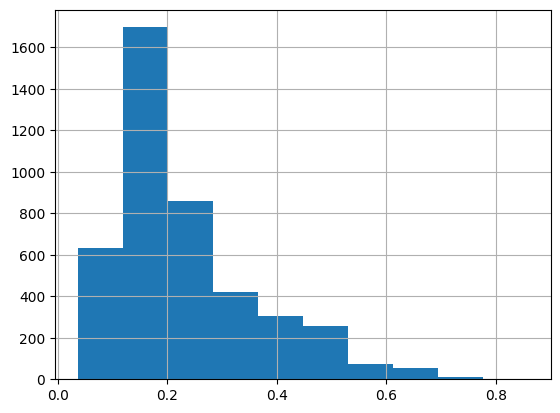

In [12]:
data['relevancy_score'].hist()